# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 марта, -4 балла после 06:00 13 марта, -6 баллов после 06:00 20 марта

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [6]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [3]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [7]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [8]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [9]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [10]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1.0,0.0,0.0
3,0.0,0.0,1.0
6,0.0,0.0,1.0
10,0.0,0.0,1.0
11,0.0,0.0,1.0


In [14]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [16]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8L, 27L)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [17]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]], dtype=int64)

In [18]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [27]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [30]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [21]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [31]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

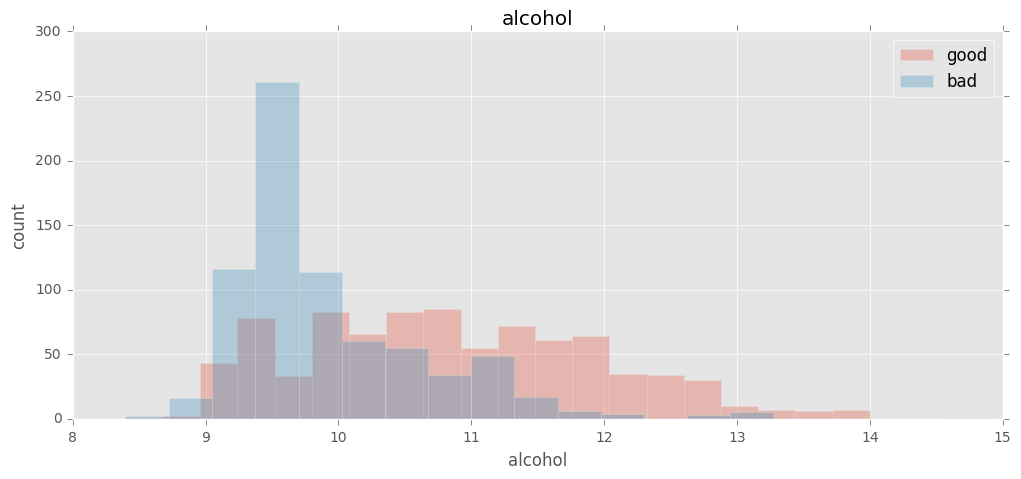

In [38]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучать классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [65]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values


Далее вы увидете пример реализации этого простого классификатора.

In [66]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор значения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [69]:
model = SimpleClassifier()
model.fit(X, y)

print ('Оптимальный порог: %f' % model.threshold)

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [70]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [71]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print ('Доля ошибок на обучающей выборке: %f' % error_rate)

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [72]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [73]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [74]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.</br> При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

#### Задание 1 (5 баллов)

Имплементируйте метод k-means

In [2]:
import numpy as np
from scipy.spatial import distance

In [143]:
from sklearn.base import BaseEstimator, ClusterMixin

class Kmeans(BaseEstimator, ClusterMixin): 

    def __init__(self, k = 6, metric=distance.euclidean, random_state=None):
        """
        Инициализация метода
        :k - количество кластеров           
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        # Инициализация параметров, полученных в конструкторе 
        self.k = k
        self.metric = metric
        
        # Инициализация генератора случайных чисел
        np.random.seed(random_state)
        
        # Инициализация остальных параметров
        self.eps = 0.0001
        
        self.iteration = 0
       
    # Ищем центроиды
    def _initialize_centroids(self, X):
        size = X.shape[0]
        self.centroids[0] = X[np.random.rand() * (size - 1)]
        
        list_dist = np.zeros(size)
        list_sum_dist = np.zeros(size)
        
        for j in range(self.k - 1):
            for i in range(size):
                _, dist = self._dist_to_centroid(X[i])
                list_dist[i] = dist ** 2

            list_sum_dist[0] = list_dist[0]
            for i in range(size - 1):
                list_sum_dist[i + 1] = list_sum_dist[i] + list_dist[i + 1]

            sum_dist = list_sum_dist[size - 1]
            rand_sum = np.random.rand() * sum_dist
            i = 0
            while rand_sum < list_sum_dist[i]:
                i = i + 1

            self.centroids = np.vstack((self.centroids, X[i]))
            
    # Минимальное расстояние до центроида
    def _dist_to_centroid(self, x):
        dist = 1000000000
        
        size = len(self.centroids)
        for i in range(size):
            if (self.metric(x, self.centroids[i]) < dist):
                dist = self.metric(x, self.centroids[i])
                label = i
               
        result = [label, dist]
        return result
        
    def fit(self, X, y=None):
        # сохраняем размерность точки       
        size = X.shape[1]
        
        # Массив с центройдами кластеров
        self.centroids = np.zeros((1, size))
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        self.predict = np.empty(X.shape[0])
        
        # Поиск минимумов и максимумов
        for i in range(size):
            min_X = np.min(X, axis=0)
            max_X = np.max(X, axis=0) 
            
        
        # Существует проблема для выбора начальных центроидов. В стандартной реализации используется случайный выбор точек,
        # но при таком подходе мой алгоритм расходился и выходл в бесконечный цикл. Поэтому я решил использовать алгоритм -
        # - k-means++. 
        
        # Ссылка на википедию:
        # https://ru.wikipedia.org/wiki/K-means%2B%2B
        self._initialize_centroids(X)
        self.r = np.zeros(self.centroids.shape)
            
        ## Your Code Here
        while (True):
            self.iteration+= 1
            for i in range(X.shape[0]):
                self.labels[i], _ = self._dist_to_centroid(X[i])
                        
            for i in range(self.k):
                if  X[self.labels == i, :].shape[0] != 0:
                    self.r[i] = self.centroids[i].copy()
                    self.centroids[i] = np.mean(X[self.labels == i, :], axis = 0)
            
            flag = 0
            print('number of iteration: {0}'.format(self.iteration))
            for i in range(self.k):
                dist_ = self.metric(self.r[i], self.centroids[i])
                if (dist_ > self.eps):
                    flag = 1
                    break;
            if (flag == 0):
                break;
                    
        return self

    def prediction(self, X, y=None):

        for i in range(X.shape[0]):
                dist = 100000000
                for j in range(self.k):
                    if (distance.euclidean(X[i], self.centroids[j]) < dist):
                        dist = distance.euclidean(X[i], self.centroids[j])
                        self.predict[i] = j
        return self.predict


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, желатено испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

#### Задание 2 (1 балл) 

Проверьте вашу имплементацию на простых данных

number of iteration: 1
number of iteration: 2
number of iteration: 3
number of iteration: 4


C:\Users\Python\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


4

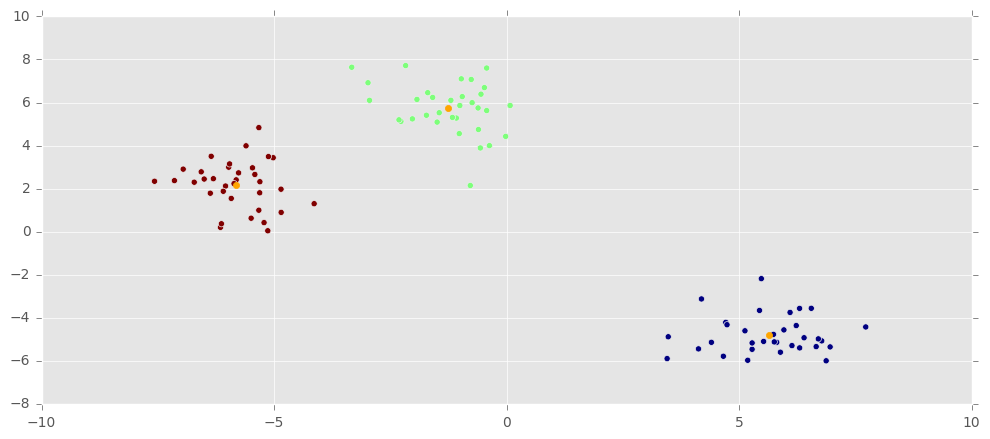

In [144]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

K = Kmeans(k = 3)
K = K.fit(X)
plt.scatter(X[:,0], X[:, 1], c=K.labels)
plt.scatter(K.centroids[:, 0], K.centroids[:, 1], color = 'orange')
K.iteration

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.

In [145]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

#### Задание 3 (4 балла)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)

In [146]:
## Your Code Here
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
work_data = df_sns.loc[:,df_sns.columns[4:]]
work_data_scaled = min_max_scaler.fit_transform(work_data)
#work_data_scaled = preprocessing.scale(work_data)

    

In [147]:
K = Kmeans(k = 9)
K = K.fit(work_data_scaled)
work_labels = K.prediction(work_data_scaled)


C:\Users\Python\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


number of iteration: 1
number of iteration: 2
number of iteration: 3
number of iteration: 4
number of iteration: 5
number of iteration: 6
number of iteration: 7
number of iteration: 8
number of iteration: 9
number of iteration: 10
number of iteration: 11
number of iteration: 12
number of iteration: 13
number of iteration: 14
number of iteration: 15
number of iteration: 16
number of iteration: 17
number of iteration: 18
number of iteration: 19
number of iteration: 20
number of iteration: 21
number of iteration: 22
number of iteration: 23
number of iteration: 24
number of iteration: 25
number of iteration: 26
number of iteration: 27
number of iteration: 28
number of iteration: 29
number of iteration: 30
number of iteration: 31
number of iteration: 32
number of iteration: 33
number of iteration: 34
number of iteration: 35
number of iteration: 36
number of iteration: 37


In [148]:
# Количеств элементов в кластере
import collections
collections.Counter(K.labels)

Counter({0.0: 734,
         1.0: 5018,
         2.0: 15210,
         3.0: 542,
         4.0: 679,
         5.0: 2552,
         6.0: 1951,
         7.0: 1860,
         8.0: 1454})

In [149]:
# Координаты центроидов.
for i in range(len(work_data.columns)):
    print((work_data.columns[i]))
    for j in range(9):
        print(j, " ", K.centroids[j][i])

basketball
(0, ' ', 0.023331062670299735)
(1, ' ', 0.011317590009299815)
(2, ' ', 0.0065609248301556431)
(3, ' ', 0.015528905289052909)
(4, ' ', 0.018286696121747676)
(5, ' ', 0.011788140020898679)
(6, ' ', 0.037822484196138713)
(7, ' ', 0.011290322580645173)
(8, ' ', 0.010144429160935333)
football
(0, ' ', 0.031880108991825543)
(1, ' ', 0.011053540587219498)
(2, ' ', 0.0051764190225729121)
(3, ' ', 0.024231242312423108)
(4, ' ', 0.033873343151693602)
(5, ' ', 0.011206896551724108)
(6, ' ', 0.1196309584828278)
(7, ' ', 0.015017921146953366)
(8, ' ', 0.01439706556625398)
soccer
(0, ' ', 0.0095367847411444318)
(1, ' ', 0.011093397103759851)
(2, ' ', 0.0060754376993693918)
(3, ' ', 0.0094984283176165127)
(4, ' ', 0.0099274532264223107)
(5, ' ', 0.0081853012887495528)
(6, ' ', 0.013896007745315797)
(7, ' ', 0.010951812027080845)
(8, ' ', 0.0083804574863721899)
softball
(0, ' ', 0.018512582144574425)
(1, ' ', 0.0072796755210653525)
(2, ' ', 0.0034613450903043987)
(3, ' ', 0.0109615802040373

In [150]:
for i in range(9):
    print(i, " _____________")
    for j in range(len(work_data.columns)):
        if (K.centroids[i][j] > work_data[work_data.columns[j]].mean() - 0.15* work_data[work_data.columns[j]].std()):
            print(K.centroids[i][j], " ", work_data.columns[j])

(0, ' _____________')
(0.0098092643051771126, ' ', 'tennis')
(0.0070596977953926157, ' ', 'marching')
(0.0027247956403269741, ' ', 'bible')
(0.0010540876100959115, ' ', 'blonde')
(0.2893392370572207, ' ', 'clothes')
(0.041023312140478267, ' ', 'hollister')
(0.029291553133514985, ' ', 'abercrombie')
(0.016433923705722071, ' ', 'drugs')
(1, ' _____________')
(0.0035689698902134164, ' ', 'marching')
(0.0020290590238776786, ' ', 'bible')
(0.00029130603832319777, ' ', 'blonde')
(0.010985452371462734, ' ', 'abercrombie')
(2, ' _____________')
(0.0036997190843344866, ' ', 'marching')
(0.0017751479289940812, ' ', 'bible')
(0.00012666702857246187, ' ', 'blonde')
(3, ' _____________')
(0.004025494800402549, ' ', 'marching')
(0.0021804763502180475, ' ', 'bible')
(0.29233292332923555, ' ', 'dress')
(0.00037238904499136717, ' ', 'blonde')
(0.010608856088560886, ' ', 'abercrombie')
(4, ' _____________')
(0.3231876943217179, ' ', 'cheerleading')
(0.0022760744410228943, ' ', 'marching')
(0.00240996117

Анализ кластеров.

1ый кластер - потребители, любят одежду, фастфуд и наркотики,
2ой кластер - аберкромби,
3ий кластер - нет явных признаков
4ий кластер - девушки (есть dress),
5ый кластер - черлидерши,
6ый кластер - нет явных признаков
7ый кластер - спортсмены
8ой кластер - девушки (есть hot)
9ой кластер - тусовщики(алкоголь и наркотики)